In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
import sys
from pathlib import Path
import sys
sys.path.append("../")
from src.model_testing import *
import pickle


In [266]:
#'country' or 'state'
division = 'country'
region = 'United States'
#'ConfirmedCases' or 'ConfirmedDeaths'
prediction = 'ConfirmedCases'

full_df = get_covid_data()
if division == 'country':
    df = full_df[(full_df['Jurisdiction'] == 'NAT_TOTAL') & (full_df['CountryName'] == region)][:-1]
elif division == 'state':
    df = full_df[(full_df['Jurisdiction'] == 'STATE_TOTAL') & (full_df['RegionName'] == region)][:-1]

#remove unneeded columns and set date as index (necessary for SARIMA model)
df = df.iloc[:,5:]
cols = [c for c in df.columns if (c.lower()[-10:] != 'fordisplay') and (c.lower()[-4:] != 'flag')]
df = df[cols]
df = df.set_index('Date', drop=True)

#drop columns with no data and forward-fill missing data after first non nan value
df = df.dropna(how='all', axis=1)
df = df.fillna(method = 'ffill')

#remove days before first infections
df = df[df[prediction] > 0]

#train-test split
train_df = df[df.index < '2020-12-01']
test_df = df[df.index >= '2020-12-01']

additional_regressors = df.drop(columns = [col for col in df.columns if col in ['ConfirmedDeaths','ConfirmedCases']])

# Plotting new cases:
We see below that there is a weekly seasonality to the diagnosis of new daily cases.

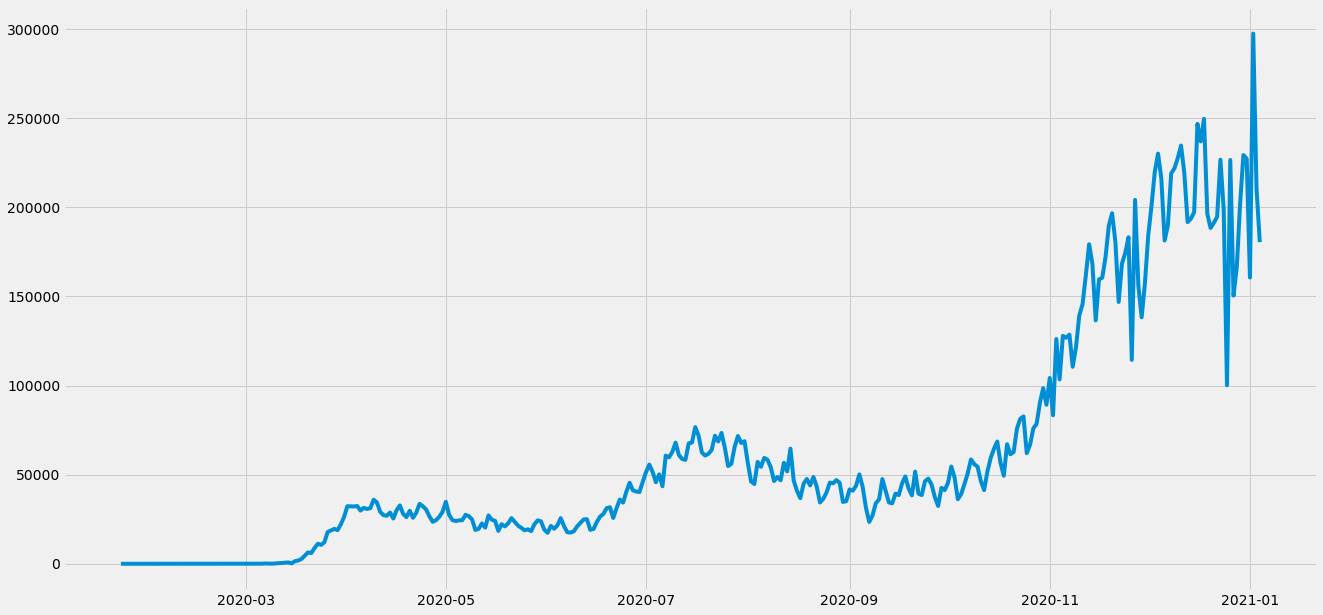

In [268]:
# differencing of one day turns total cases into daily new cases
# by tracking the change rather than the total
plt.plot(df[prediction].diff(1)[:])  

Above, we see a weekly seasonality in the decomposition.  We also see exploding variance in the residuals after October.  We also see that the decomposition failed to revmove the seasonality in the residuals for the first half of the year.

Lets see if we can get a better decomposition

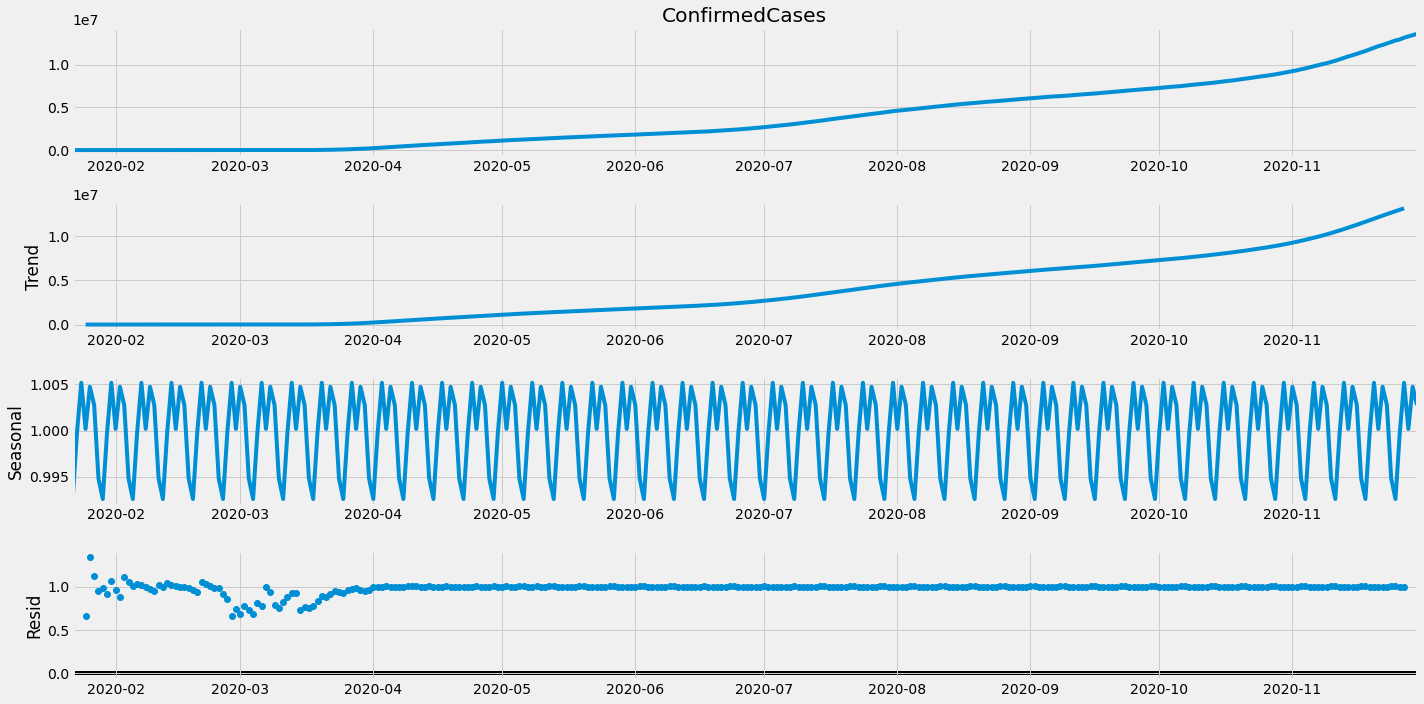

In [41]:
results = seasonal_decompose(train_df['ConfirmedCases'],two_sided = True, model='multiplicative')
results.plot()
plt.show()

Let's take a look at this seasonality.  Where is it coming from?  


The below bar plot of average infections per day of the week suggests that test results are most often reported on Mondays and least often reported on Wednesdays.  The number of reports seems to escalate steadily from Wednesday to Monday. It seems unlikely that these numbers represent the days people are actually infected on.  I imagine the data is entered sometime after tests come back, which is between 2 and 5 days after testing.  PCR tests are most accurate 5+ days after exposure, so we can assume reported cases lag by 7-10 days.  I would guess that the greater number of reports on Mondays has to do with either the workflow patterns in laboratories, or the patterns of when people tend to go in for tests. 

NOTE: y-axis begins at 3.6m.

Text(0.5, 0, 'Day of the Week')

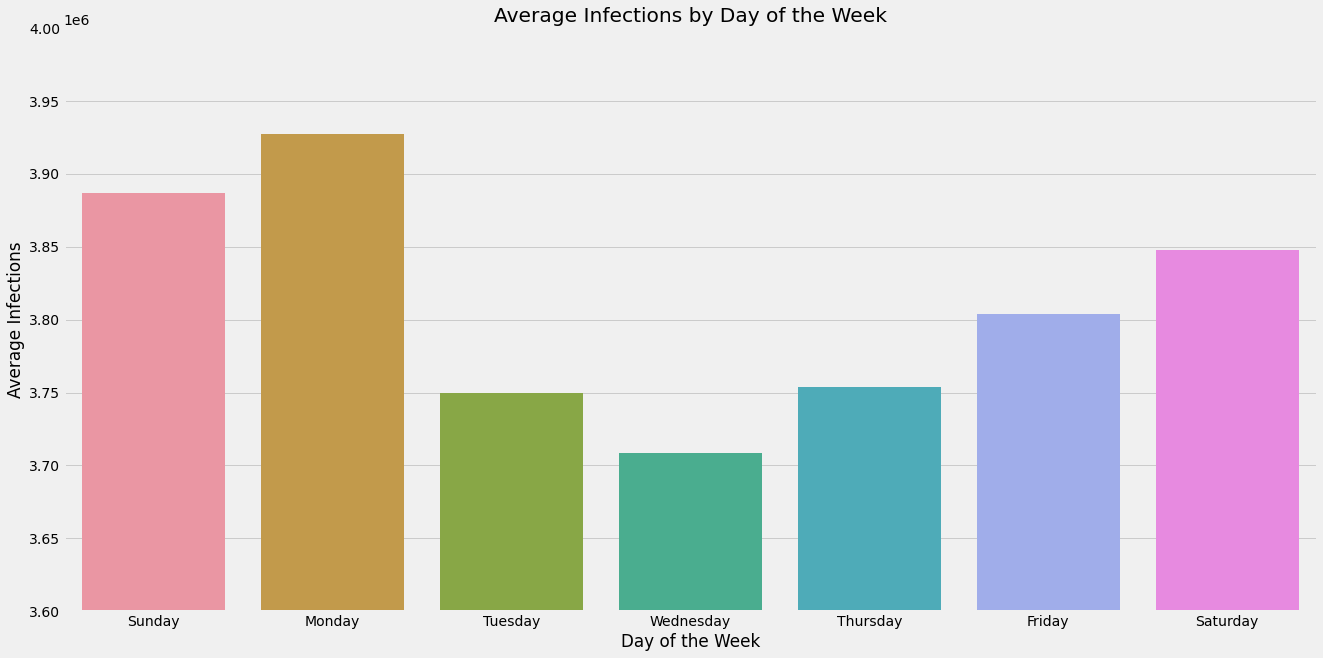

In [269]:
import seaborn as sns
ax = plt.subplot()
sns.barplot(x=train_df.index.day_name(), y=train_df[prediction].values, ax=ax, ci=False,
           order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
ax.set_ylim([3600000,4000000])
ax.set_title('Average Infections by Day of the Week')
ax.set_ylabel('Average Infections')
ax.set_xlabel('Day of the Week')

# SARIMA

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In our ACF plot we see the effects of our weekly seasonality at 7, 14, and 21 days.  We also see jumps in autocorrelation in the days before and after those.  My guess is that testing is most often done on weekends.  Let's do a visual inspection to see if that is true.

In [277]:
train = train_df[prediction]
test = test_df[prediction]
true = df[prediction]
train.index.freq = 'D'
test.index.freq = 'D'
true.index.freq = 'D'

# Testing for Stationarity

In [271]:
from statsmodels.tsa.stattools import adfuller


First, let's see if we can remove the seasonality with seasonal lagged differencing.

(2.3605219083303774,
 0.9989905031557418,
 17,
 331,
 {'1%': -3.4502615951739393,
  '5%': -2.8703117734117742,
  '10%': -2.5714433728242714},
 7191.322664100193)

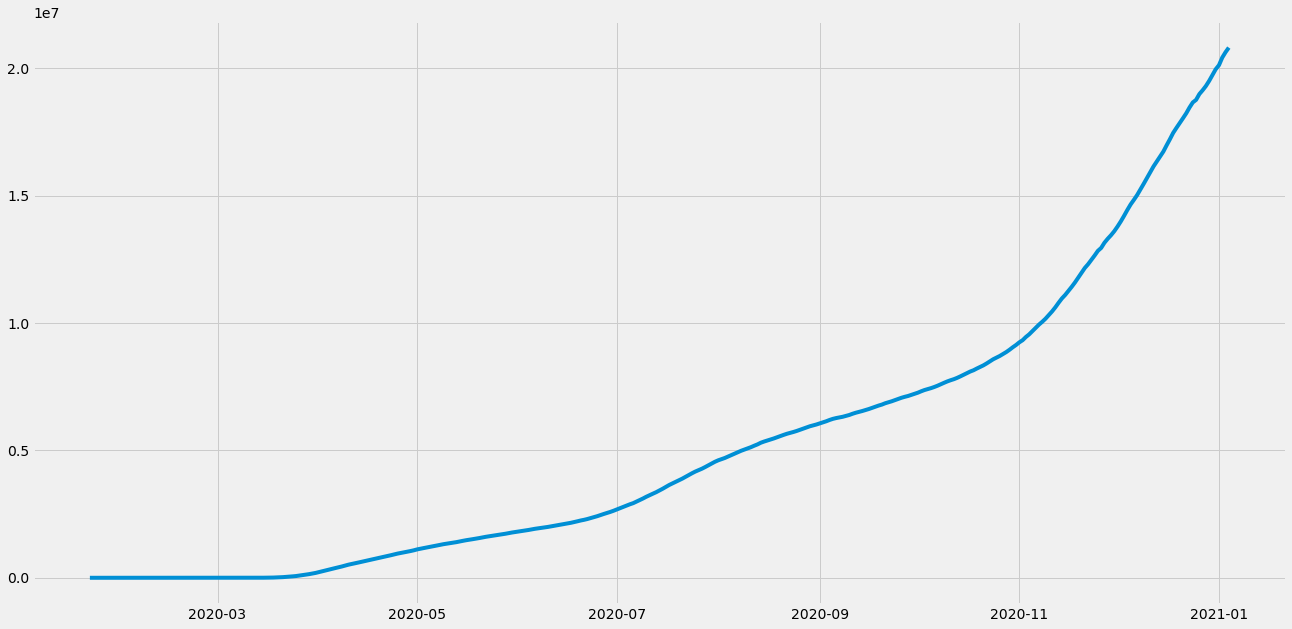

In [331]:
plt.plot(true)
adfuller(true)


(-1.0089533288241526,
 0.9428975000387799,
 8,
 339,
 {'1%': -3.98572612322781, '5%': -3.42352082505902, '10%': -3.134711867001672},
 7243.33806617171)

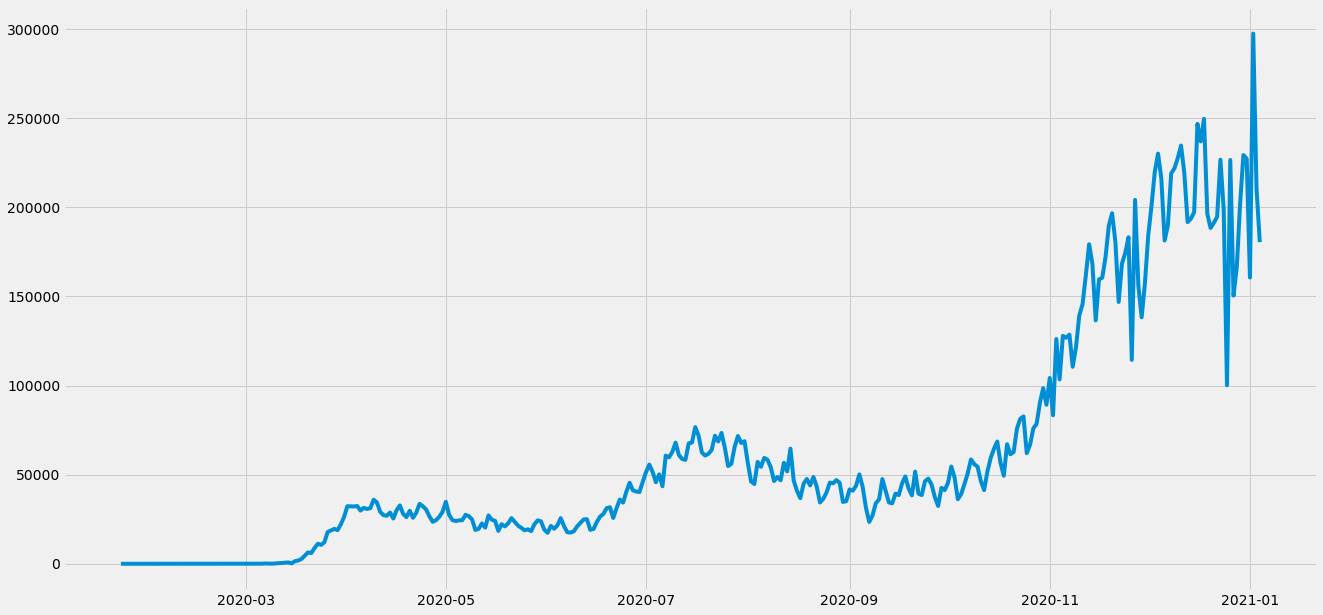

In [332]:
train_diff = true.diff(1).dropna()
plt.plot(train_diff)
adresults = adfuller(train_diff, autolag = 'BIC', regression = 'ct')
adresults

Above, we do a first order differencing, which, as mentioned, transforms cumulative cases to daily new cases.  This makes the data stationary at a lag of 11.  We will remember this number for our AM model. 

Below we will try a second order differencing.

(-1.0519061185527294,
 0.9367114950203088,
 10,
 331,
 {'1%': -3.9863839265077425,
  '5%': -3.423837774131041,
  '10%': -3.1348979222834137},
 7118.77148893183)

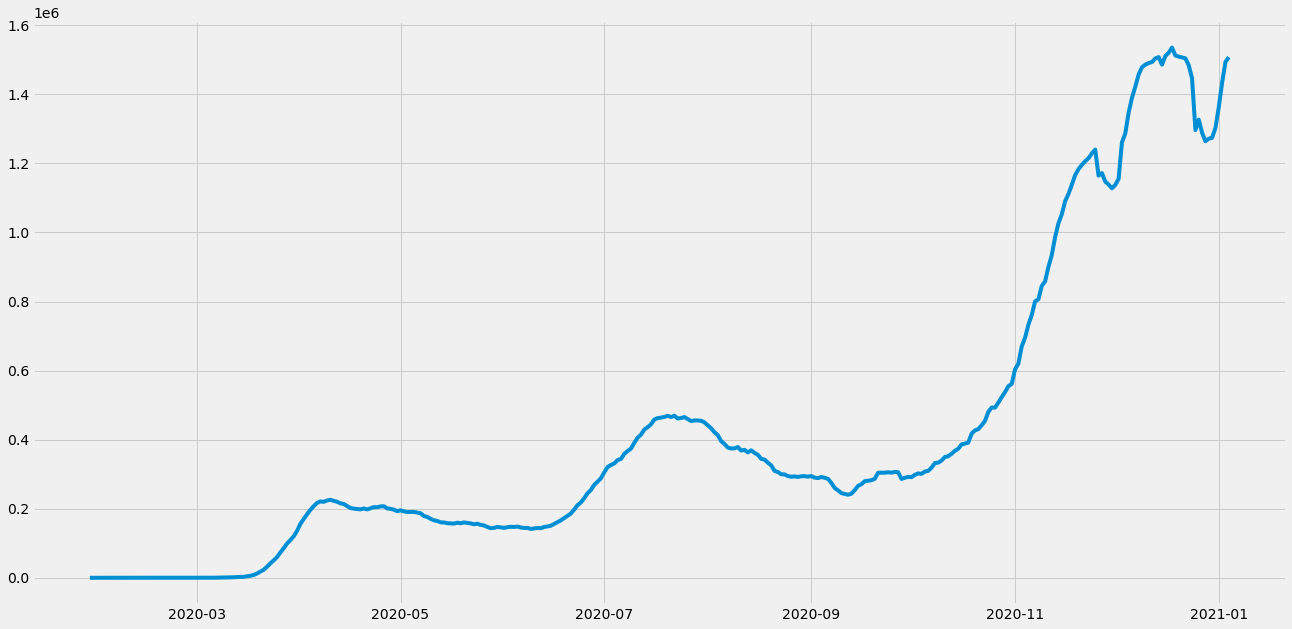

In [333]:
train_diff_week = true.diff(7).dropna()
plt.plot(train_diff_week)
adresults = adfuller(train_diff_week, autolag = 'BIC', regression = 'ct')
adresults

Let's try a second order differencing to remove the trend as well.  This will be equivalent to the ARIMA model having a difference of 1 and the seasonal adjustment a difference of 7.

(-3.9139812353234706,
 0.011606377590309181,
 9,
 331,
 {'1%': -3.9863839265077425,
  '5%': -3.423837774131041,
  '10%': -3.1348979222834137},
 7093.369768333682)

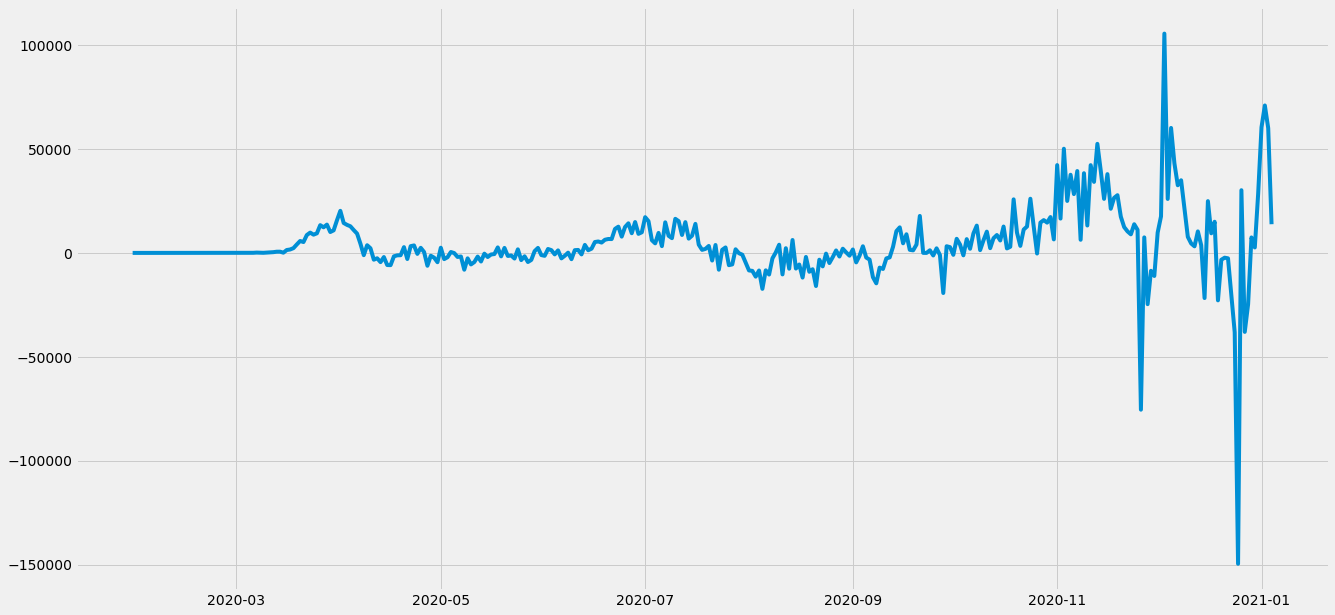

In [334]:
train_diff_week2 = true.diff(7).diff(1).dropna()
plt.plot(train_diff_week2)
adresults = adfuller(train_diff_week2, autolag = 'BIC', regression = 'ct')
adresults

The second order differencing removed the trend from our data, but the variance is not constant yet.  Another trick we can try is a cube root transformation to reduce the variance change.

(-4.259952944873755,
 0.0036279751159395118,
 13,
 327,
 {'1%': -3.9867250165057078,
  '5%': -3.424002102034151,
  '10%': -3.134994380293157},
 -122.66698675586129)

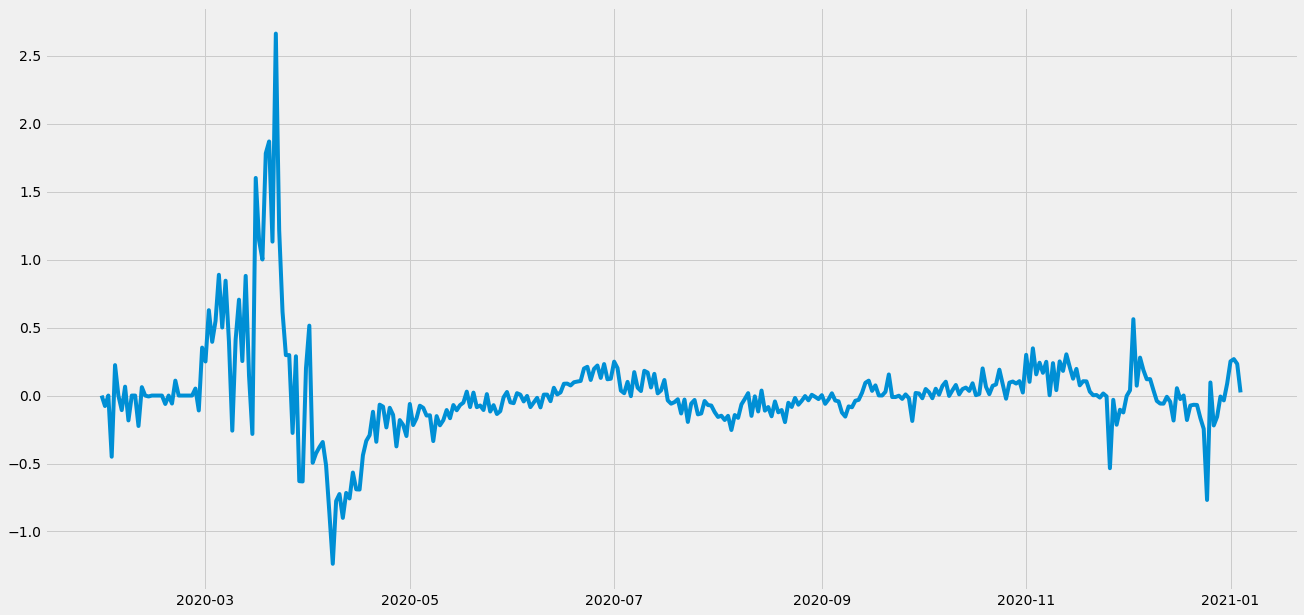

In [335]:
rolling_diff2 = np.cbrt(true).diff(7).diff(1).dropna()
plt.plot(rolling_diff2)
adresults = adfuller(rolling_diff2, autolag = 'BIC', regression = 'ct')
adresults

We pass the Dicky-Fuller and the change in variance does not seem to trend over our data set.  It's pretty localized to March and April.  We will cbrt transform our data and tell our model to use a seasonal lag of 7 days and an ARMA difference of 1 day lag.  Let's use ACF and a PACF charts to find clues to the best AR and MA lags.

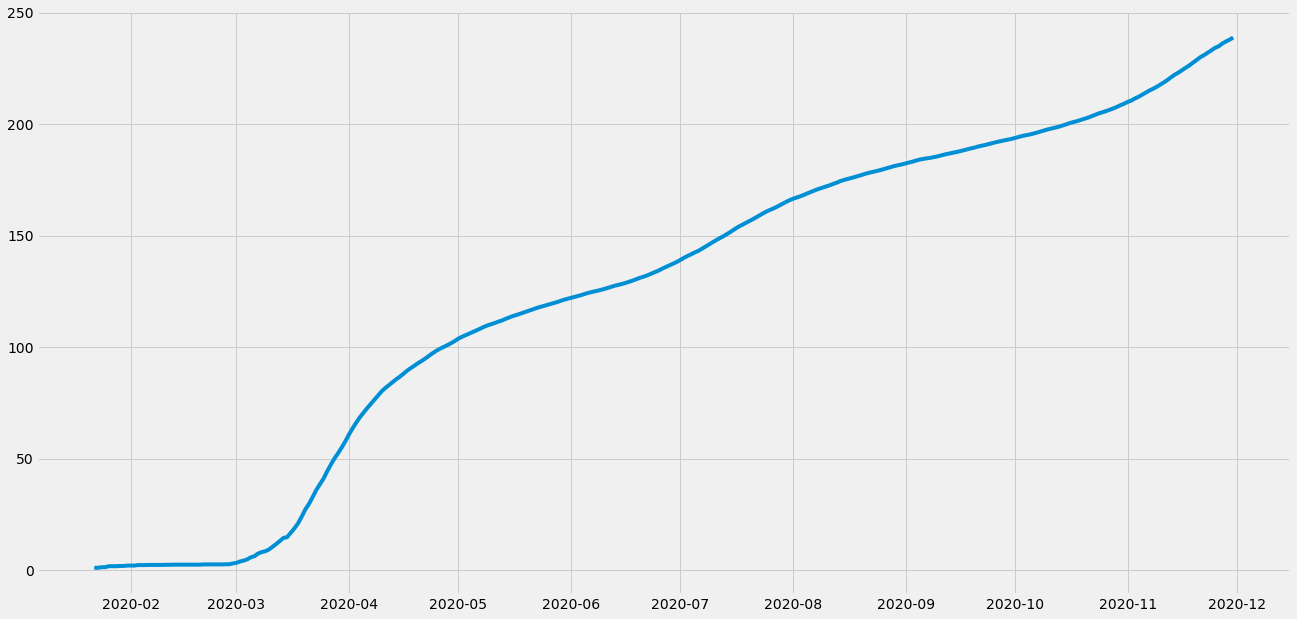

In [342]:
plt.plot(cbrt_train)

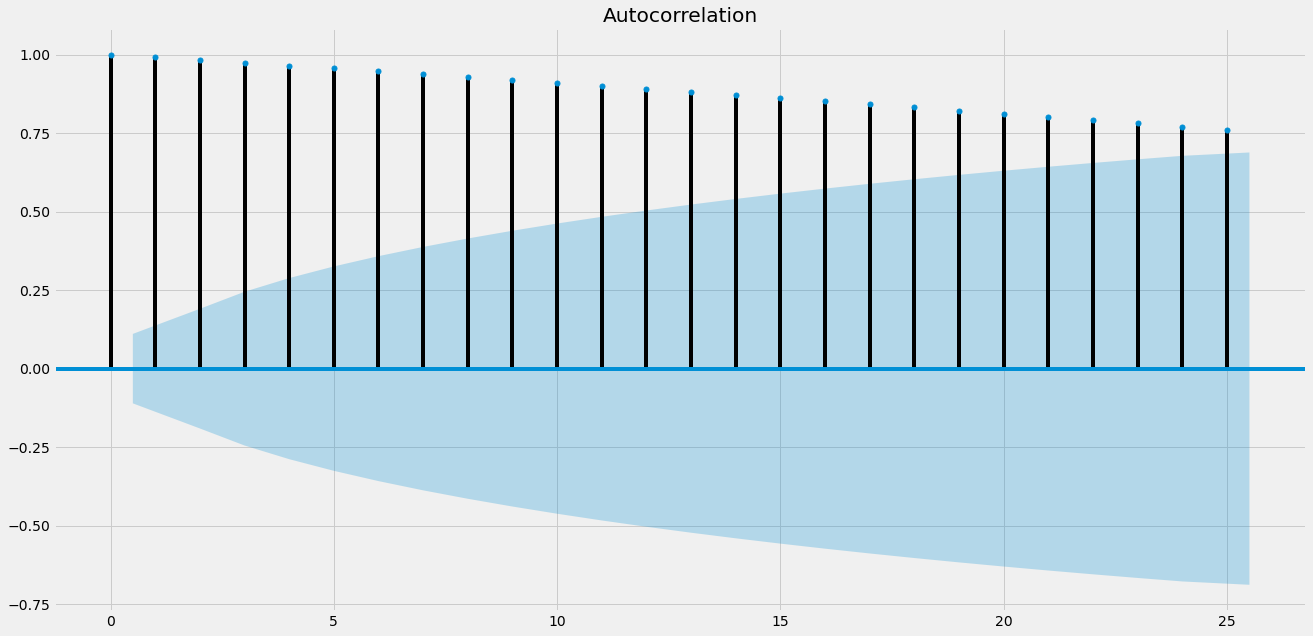

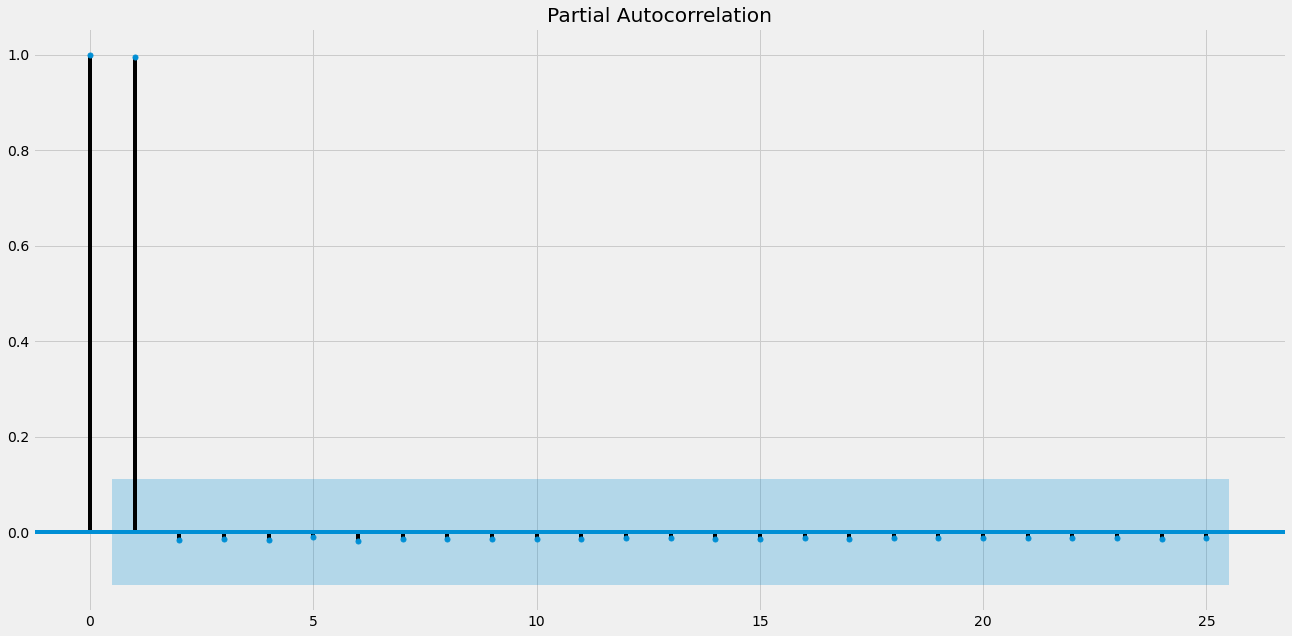

In [341]:
cbrt_train =  np.cbrt(train)
plot_acf(cbrt_train)
plot_pacf(cbrt_train)
plt.show()

The spike at lag 1 in the PACF tells us we want an AR setting of 1 and the gradual drop off of the ACF suggests we set the MA lag to 0.

We will start with a simpler model below, without dealing with the seasonality and built to a more complex model.

simple arima mean percent error:  0.07423322723807446


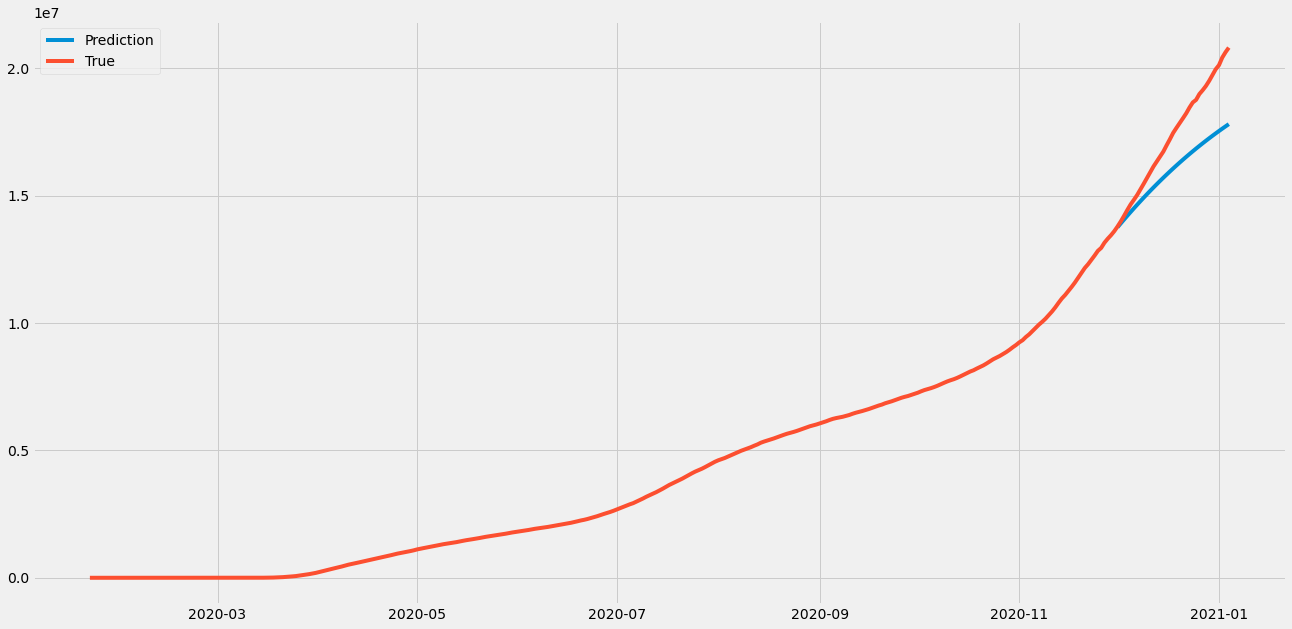

In [354]:
arimamodel = SARIMAX(cbrt_train, order = (1,1,0))
fit_model = arimamodel.fit()
yhat = fit_model.forecast(len(test))
# undo the cube root in order to compare to the test data
yhat = yhat**3
mpe = mean_percent_error(test,yhat)
print('simple arima mean percent error: ', mpe)
plt.plot(yhat, label = 'Prediction')
plt.plot(true, label = 'True')
plt.legend()
plt.show()

This is fine for a start, but lets try adding the seasonal element, a SARIMA model.

simple arima mean percent error:  0.02971251354021952


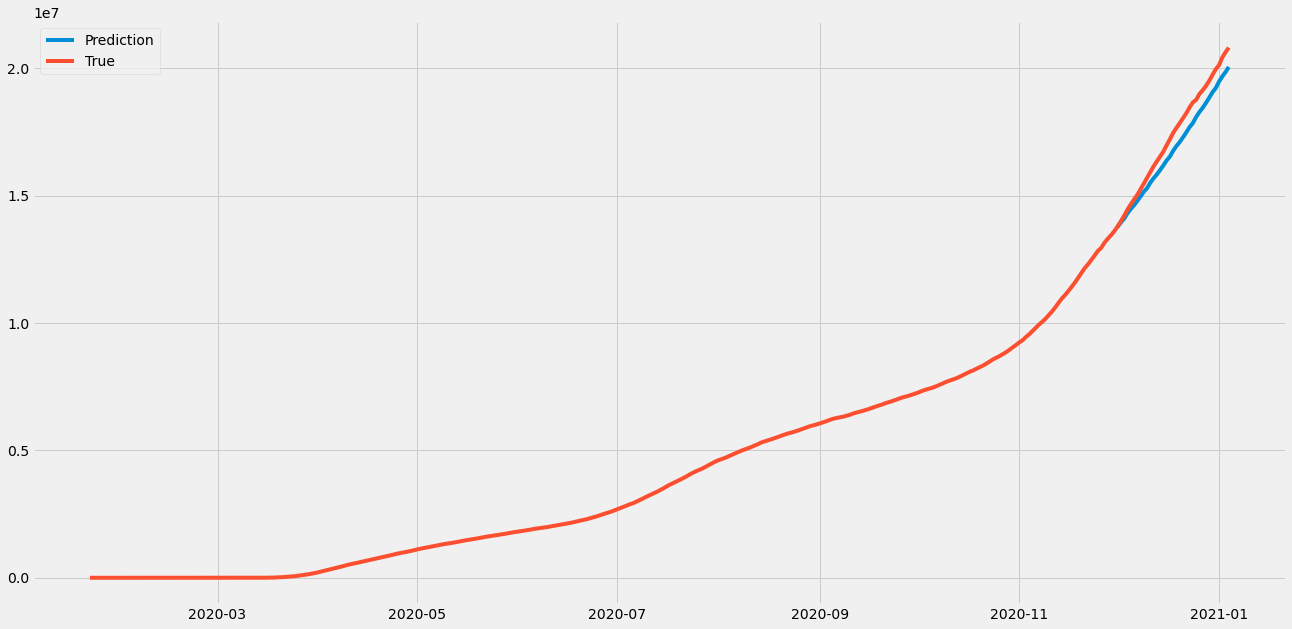

In [357]:
arimamodel = SARIMAX(cbrt_train, order = (1,1,0), seasonal_order = (1,1,0,7))
fit_model = arimamodel.fit()
yhat = fit_model.forecast(len(test))
# undo the cube root in order to compare to the test data
yhat = yhat**3
mpe = mean_percent_error(test,yhat)
print('simple arima mean percent error: ', mpe)
plt.plot(yhat, label = 'Prediction')
plt.plot(true, label = 'True')
plt.legend()
plt.show()

This is much better.  Our model is only off by about 3% for the month of December and the beginning of January.

A closer examination of our data shows certain points where the trend changes.  I am seeing the beginning of April, July, middle of October, and December.  I wonder if those line up with holidays or spreading events at some lag.  Perhaps the end of the March lockdown, beginning of summer, start of school, and Thanksgiving? Adding holidays or events where people gather might help the model account for these.

In [364]:
test_results = pd.DataFrame(columns = ['MPE'])
for p in range(0,4):
    for d in range(1,3):
        for q in range(0,4):
            for P in range(0,4):
                for D in range(1,3):
                    for Q in range(0,4):
                        model = SARIMAX(cbrt_train, order =(p,d,q), seasonal_order = (P,D,Q,7),
                                       freq = 'D')
                        fit_model = model.fit(maxiter = 200, disp = False)
                        yhat = fit_model.forecast(len(test))
                        yhat = yhat**3
                        ind = f'order = ({p},{d},{q}), seasonal_order = ({P},{D},{Q},7)'
                        mpe = mean_percent_error(test,yhat)
                        print(f'trying {ind}, MPE = {mpe}')
                        test_results.loc[ind,'MPE'] = mpe

test_results.min()

trying order = (0,1,0), seasonal_order = (0,1,0,7), MPE = 0.024269935949736327
trying order = (0,1,0), seasonal_order = (0,1,1,7), MPE = 0.03034650611871245
trying order = (0,1,0), seasonal_order = (0,1,2,7), MPE = 0.03891634071867059
trying order = (0,1,0), seasonal_order = (0,1,3,7), MPE = 0.03750655713491045
trying order = (0,1,0), seasonal_order = (0,2,0,7), MPE = 0.08394313681076289
trying order = (0,1,0), seasonal_order = (0,2,1,7), MPE = 0.015434024876489387
trying order = (0,1,0), seasonal_order = (0,2,2,7), MPE = 0.023063386458485675
trying order = (0,1,0), seasonal_order = (0,2,3,7), MPE = 0.034196086341636026
trying order = (0,1,0), seasonal_order = (1,1,0,7), MPE = 0.03333376049730896
trying order = (0,1,0), seasonal_order = (1,1,1,7), MPE = 0.03331734298992189
trying order = (0,1,0), seasonal_order = (1,1,2,7), MPE = 0.03814573203365595
trying order = (0,1,0), seasonal_order = (1,1,3,7), MPE = 0.05453511750402972
trying order = (0,1,0), seasonal_order = (1,2,0,7), MPE = 0.

trying order = (0,1,3), seasonal_order = (1,1,1,7), MPE = 0.05783301902292139
trying order = (0,1,3), seasonal_order = (1,1,2,7), MPE = 0.05372877998511221
trying order = (0,1,3), seasonal_order = (1,1,3,7), MPE = 0.0539964829771137
trying order = (0,1,3), seasonal_order = (1,2,0,7), MPE = 0.06409349639458377
trying order = (0,1,3), seasonal_order = (1,2,1,7), MPE = 0.019863060100853883
trying order = (0,1,3), seasonal_order = (1,2,2,7), MPE = 0.018871277864471056
trying order = (0,1,3), seasonal_order = (1,2,3,7), MPE = 0.019067635502638437
trying order = (0,1,3), seasonal_order = (2,1,0,7), MPE = 0.027784199914390132
trying order = (0,1,3), seasonal_order = (2,1,1,7), MPE = 0.05325344501013622
trying order = (0,1,3), seasonal_order = (2,1,2,7), MPE = 0.05358364347399245
trying order = (0,1,3), seasonal_order = (2,1,3,7), MPE = 0.046983771113224486
trying order = (0,1,3), seasonal_order = (2,2,0,7), MPE = 0.03912287399248655
trying order = (0,1,3), seasonal_order = (2,2,1,7), MPE = 0.

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,2,0), seasonal_order = (0,2,1,7), MPE = 0.08060164425145382
trying order = (0,2,0), seasonal_order = (0,2,2,7), MPE = 0.02879962835515613
trying order = (0,2,0), seasonal_order = (0,2,3,7), MPE = 0.026521418187426062
trying order = (0,2,0), seasonal_order = (1,1,0,7), MPE = 0.05894328291421664
trying order = (0,2,0), seasonal_order = (1,1,1,7), MPE = 0.014992324870402113
trying order = (0,2,0), seasonal_order = (1,1,2,7), MPE = 0.014865977268605501
trying order = (0,2,0), seasonal_order = (1,1,3,7), MPE = 0.014793012249957745
trying order = (0,2,0), seasonal_order = (1,2,0,7), MPE = 0.18493518832237207
trying order = (0,2,0), seasonal_order = (1,2,1,7), MPE = 0.06138266907982895
trying order = (0,2,0), seasonal_order = (1,2,2,7), MPE = 0.026872789595756712
trying order = (0,2,0), seasonal_order = (1,2,3,7), MPE = 0.027237155706602366
trying order = (0,2,0), seasonal_order = (2,1,0,7), MPE = 0.027637860577097953
trying order = (0,2,0), seasonal_order = (2,1,1,7), MPE =

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,2,3), seasonal_order = (0,1,0,7), MPE = 0.03440778457585974
trying order = (0,2,3), seasonal_order = (0,1,1,7), MPE = 0.018598648882761293
trying order = (0,2,3), seasonal_order = (0,1,2,7), MPE = 0.020976839288652738
trying order = (0,2,3), seasonal_order = (0,1,3,7), MPE = 0.023414013187852353
trying order = (0,2,3), seasonal_order = (0,2,0,7), MPE = 0.14311165724360164
trying order = (0,2,3), seasonal_order = (0,2,1,7), MPE = 0.03741809146771017
trying order = (0,2,3), seasonal_order = (0,2,2,7), MPE = 0.015837510502536387
trying order = (0,2,3), seasonal_order = (0,2,3,7), MPE = 0.03249207798979993
trying order = (0,2,3), seasonal_order = (1,1,0,7), MPE = 0.051669829250270874
trying order = (0,2,3), seasonal_order = (1,1,1,7), MPE = 0.02175678585755458
trying order = (0,2,3), seasonal_order = (1,1,2,7), MPE = 0.02224448296323948
trying order = (0,2,3), seasonal_order = (1,1,3,7), MPE = 0.02227294447510619
trying order = (0,2,3), seasonal_order = (1,2,0,7), MPE = 0

trying order = (1,1,2), seasonal_order = (1,1,1,7), MPE = 0.03806503991294274
trying order = (1,1,2), seasonal_order = (1,1,2,7), MPE = 0.03561436167912638
trying order = (1,1,2), seasonal_order = (1,1,3,7), MPE = 0.03855367373384887
trying order = (1,1,2), seasonal_order = (1,2,0,7), MPE = 0.10312980514443523
trying order = (1,1,2), seasonal_order = (1,2,1,7), MPE = 0.03944864849544664
trying order = (1,1,2), seasonal_order = (1,2,2,7), MPE = 0.02016079247528011
trying order = (1,1,2), seasonal_order = (1,2,3,7), MPE = 0.016254143463993884
trying order = (1,1,2), seasonal_order = (2,1,0,7), MPE = 0.024948256786093734
trying order = (1,1,2), seasonal_order = (2,1,1,7), MPE = 0.038918629135631294
trying order = (1,1,2), seasonal_order = (2,1,2,7), MPE = 0.038897491589078494
trying order = (1,1,2), seasonal_order = (2,1,3,7), MPE = 0.03527823454365432
trying order = (1,1,2), seasonal_order = (2,2,0,7), MPE = 0.08095152902996747
trying order = (1,1,2), seasonal_order = (2,2,1,7), MPE = 0.

trying order = (1,2,1), seasonal_order = (2,1,2,7), MPE = 0.023550788484255833
trying order = (1,2,1), seasonal_order = (2,1,3,7), MPE = 0.020318453578712828
trying order = (1,2,1), seasonal_order = (2,2,0,7), MPE = 0.1536899613276268
trying order = (1,2,1), seasonal_order = (2,2,1,7), MPE = 0.032981740293768096
trying order = (1,2,1), seasonal_order = (2,2,2,7), MPE = 0.039295809457693454
trying order = (1,2,1), seasonal_order = (2,2,3,7), MPE = 0.03335862045457802
trying order = (1,2,1), seasonal_order = (3,1,0,7), MPE = 0.016887316116592124
trying order = (1,2,1), seasonal_order = (3,1,1,7), MPE = 0.022506554212361238
trying order = (1,2,1), seasonal_order = (3,1,2,7), MPE = 0.024344340228943117
trying order = (1,2,1), seasonal_order = (3,1,3,7), MPE = 0.020963563007409813
trying order = (1,2,1), seasonal_order = (3,2,0,7), MPE = 0.11664128073153078
trying order = (1,2,1), seasonal_order = (3,2,1,7), MPE = 0.017461351277069125
trying order = (1,2,1), seasonal_order = (3,2,2,7), MPE 

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,2,2), seasonal_order = (2,2,1,7), MPE = 0.033757664500204336
trying order = (1,2,2), seasonal_order = (2,2,2,7), MPE = 0.04560431666273675
trying order = (1,2,2), seasonal_order = (2,2,3,7), MPE = 0.03237996494620029
trying order = (1,2,2), seasonal_order = (3,1,0,7), MPE = 0.03307810841453839
trying order = (1,2,2), seasonal_order = (3,1,1,7), MPE = 0.03361226477371349
trying order = (1,2,2), seasonal_order = (3,1,2,7), MPE = 0.03511189061524295
trying order = (1,2,2), seasonal_order = (3,1,3,7), MPE = 0.03205138226092494
trying order = (1,2,2), seasonal_order = (3,2,0,7), MPE = 0.1198320551345075
trying order = (1,2,2), seasonal_order = (3,2,1,7), MPE = 0.017623507032505717
trying order = (1,2,2), seasonal_order = (3,2,2,7), MPE = 0.043710267617897494
trying order = (1,2,2), seasonal_order = (3,2,3,7), MPE = 0.044834550115378756
trying order = (1,2,3), seasonal_order = (0,1,0,7), MPE = 0.02528563332458254
trying order = (1,2,3), seasonal_order = (0,1,1,7), MPE = 0.0

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,3), seasonal_order = (0,2,0,7), MPE = 0.08492111485109112
trying order = (1,2,3), seasonal_order = (0,2,1,7), MPE = 0.027736114352510104
trying order = (1,2,3), seasonal_order = (0,2,2,7), MPE = 0.03290001177313124
trying order = (1,2,3), seasonal_order = (0,2,3,7), MPE = 0.03657329228980798
trying order = (1,2,3), seasonal_order = (1,1,0,7), MPE = 0.0522577289447016
trying order = (1,2,3), seasonal_order = (1,1,1,7), MPE = 0.022329674449337627
trying order = (1,2,3), seasonal_order = (1,1,2,7), MPE = 0.019540976674248228
trying order = (1,2,3), seasonal_order = (1,1,3,7), MPE = 0.023534880349416153
trying order = (1,2,3), seasonal_order = (1,2,0,7), MPE = 0.1387784703288175
trying order = (1,2,3), seasonal_order = (1,2,1,7), MPE = 0.0524708460972036
trying order = (1,2,3), seasonal_order = (1,2,2,7), MPE = 0.03518889923270981
trying order = (1,2,3), seasonal_order = (1,2,3,7), MPE = 0.01848882102234293
trying order = (1,2,3), seasonal_order = (2,1,0,7), MPE = 0.028

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


trying order = (2,1,1), seasonal_order = (0,1,0,7), MPE = 0.050381959436538906
trying order = (2,1,1), seasonal_order = (0,1,1,7), MPE = 0.03434577576844073
trying order = (2,1,1), seasonal_order = (0,1,2,7), MPE = 0.03668377019784083
trying order = (2,1,1), seasonal_order = (0,1,3,7), MPE = 0.037764649932236494
trying order = (2,1,1), seasonal_order = (0,2,0,7), MPE = 0.1023525699471383
trying order = (2,1,1), seasonal_order = (0,2,1,7), MPE = 0.048563453628744944
trying order = (2,1,1), seasonal_order = (0,2,2,7), MPE = 0.01757010669144376
trying order = (2,1,1), seasonal_order = (0,2,3,7), MPE = 0.018462869892352483
trying order = (2,1,1), seasonal_order = (1,1,0,7), MPE = 0.043615287858538555
trying order = (2,1,1), seasonal_order = (1,1,1,7), MPE = 0.03583491637891686
trying order = (2,1,1), seasonal_order = (1,1,2,7), MPE = 0.03244486201353976
trying order = (2,1,1), seasonal_order = (1,1,3,7), MPE = 0.037289845535734965
trying order = (2,1,1), seasonal_order = (1,2,0,7), MPE = 0

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (2,1,2), seasonal_order = (3,1,1,7), MPE = 0.035440938863497425
trying order = (2,1,2), seasonal_order = (3,1,2,7), MPE = 0.03865881939738897
trying order = (2,1,2), seasonal_order = (3,1,3,7), MPE = 0.034574247924378985
trying order = (2,1,2), seasonal_order = (3,2,0,7), MPE = 0.07170345095351142
trying order = (2,1,2), seasonal_order = (3,2,1,7), MPE = 0.016508126644432006
trying order = (2,1,2), seasonal_order = (3,2,2,7), MPE = 0.054072095579158964
trying order = (2,1,2), seasonal_order = (3,2,3,7), MPE = 0.01979061646818571
trying order = (2,1,3), seasonal_order = (0,1,0,7), MPE = 0.02104811557686323
trying order = (2,1,3), seasonal_order = (0,1,1,7), MPE = 0.036282334635274
trying order = (2,1,3), seasonal_order = (0,1,2,7), MPE = 0.038542162775170655
trying order = (2,1,3), seasonal_order = (0,1,3,7), MPE = 0.040167500449270484
trying order = (2,1,3), seasonal_order = (0,2,0,7), MPE = 0.10073588229549321
trying order = (2,1,3), seasonal_order = (0,2,1,7), MPE = 0.

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (2,1,3), seasonal_order = (3,1,3,7), MPE = 0.05914722173445919
trying order = (2,1,3), seasonal_order = (3,2,0,7), MPE = 0.03590577825470303
trying order = (2,1,3), seasonal_order = (3,2,1,7), MPE = 0.01780737954708137
trying order = (2,1,3), seasonal_order = (3,2,2,7), MPE = 0.0515651611669146
trying order = (2,1,3), seasonal_order = (3,2,3,7), MPE = 0.020369299240680278
trying order = (2,2,0), seasonal_order = (0,1,0,7), MPE = 0.08228855813243838
trying order = (2,2,0), seasonal_order = (0,1,1,7), MPE = 0.020439503553690393
trying order = (2,2,0), seasonal_order = (0,1,2,7), MPE = 0.0236413014782617
trying order = (2,2,0), seasonal_order = (0,1,3,7), MPE = 0.026775707147029357
trying order = (2,2,0), seasonal_order = (0,2,0,7), MPE = 0.17877911080081255
trying order = (2,2,0), seasonal_order = (0,2,1,7), MPE = 0.08348863977274373
trying order = (2,2,0), seasonal_order = (0,2,2,7), MPE = 0.01860239164921015
trying order = (2,2,0), seasonal_order = (0,2,3,7), MPE = 0.039

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (2,2,2), seasonal_order = (3,2,2,7), MPE = 0.05070953075988901
trying order = (2,2,2), seasonal_order = (3,2,3,7), MPE = 0.05019068561101797
trying order = (2,2,3), seasonal_order = (0,1,0,7), MPE = 0.08975461187586439
trying order = (2,2,3), seasonal_order = (0,1,1,7), MPE = 0.014413141995314729
trying order = (2,2,3), seasonal_order = (0,1,2,7), MPE = 0.023700202061195663
trying order = (2,2,3), seasonal_order = (0,1,3,7), MPE = 0.024284360205215332
trying order = (2,2,3), seasonal_order = (0,2,0,7), MPE = 0.025859075909142243
trying order = (2,2,3), seasonal_order = (0,2,1,7), MPE = 0.057278358539932635
trying order = (2,2,3), seasonal_order = (0,2,2,7), MPE = 0.048267868685201984
trying order = (2,2,3), seasonal_order = (0,2,3,7), MPE = 0.04655159250692754
trying order = (2,2,3), seasonal_order = (1,1,0,7), MPE = 0.0529777952742011
trying order = (2,2,3), seasonal_order = (1,1,1,7), MPE = 0.02456606130073008
trying order = (2,2,3), seasonal_order = (1,1,2,7), MPE = 0

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (2,2,3), seasonal_order = (3,2,2,7), MPE = 0.051086681893205005
trying order = (2,2,3), seasonal_order = (3,2,3,7), MPE = 0.05019031787259199
trying order = (3,1,0), seasonal_order = (0,1,0,7), MPE = 0.05424323940073083
trying order = (3,1,0), seasonal_order = (0,1,1,7), MPE = 0.034160100920439716
trying order = (3,1,0), seasonal_order = (0,1,2,7), MPE = 0.03760477604130036
trying order = (3,1,0), seasonal_order = (0,1,3,7), MPE = 0.03914975686118775
trying order = (3,1,0), seasonal_order = (0,2,0,7), MPE = 0.10943234879392084
trying order = (3,1,0), seasonal_order = (0,2,1,7), MPE = 0.05276521582323471
trying order = (3,1,0), seasonal_order = (0,2,2,7), MPE = 0.01994451052104512
trying order = (3,1,0), seasonal_order = (0,2,3,7), MPE = 0.028430756396502138
trying order = (3,1,0), seasonal_order = (1,1,0,7), MPE = 0.04748426440909008
trying order = (3,1,0), seasonal_order = (1,1,1,7), MPE = 0.031317310878084335
trying order = (3,1,0), seasonal_order = (1,1,2,7), MPE = 0.

trying order = (3,1,3), seasonal_order = (0,2,3,7), MPE = 0.03184574124494569
trying order = (3,1,3), seasonal_order = (1,1,0,7), MPE = 0.04797216563741248
trying order = (3,1,3), seasonal_order = (1,1,1,7), MPE = 0.045722498605620575
trying order = (3,1,3), seasonal_order = (1,1,2,7), MPE = 0.04516221633658884
trying order = (3,1,3), seasonal_order = (1,1,3,7), MPE = 0.0484832786146266
trying order = (3,1,3), seasonal_order = (1,2,0,7), MPE = 0.10759217744787555
trying order = (3,1,3), seasonal_order = (1,2,1,7), MPE = 0.029886235038130357
trying order = (3,1,3), seasonal_order = (1,2,2,7), MPE = 0.03628501086056318
trying order = (3,1,3), seasonal_order = (1,2,3,7), MPE = 0.015872576666353975
trying order = (3,1,3), seasonal_order = (2,1,0,7), MPE = 0.037747913387597816
trying order = (3,1,3), seasonal_order = (2,1,1,7), MPE = 0.04739317440540206
trying order = (3,1,3), seasonal_order = (2,1,2,7), MPE = 0.0471686356320316


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (3,1,3), seasonal_order = (2,1,3,7), MPE = 0.049676287916267825
trying order = (3,1,3), seasonal_order = (2,2,0,7), MPE = 0.049095921163929766
trying order = (3,1,3), seasonal_order = (2,2,1,7), MPE = 0.035713821665294285
trying order = (3,1,3), seasonal_order = (2,2,2,7), MPE = 0.06647981654207451
trying order = (3,1,3), seasonal_order = (2,2,3,7), MPE = 0.029419354989240455
trying order = (3,1,3), seasonal_order = (3,1,0,7), MPE = 0.031203780681815684
trying order = (3,1,3), seasonal_order = (3,1,1,7), MPE = 0.046939044167255646
trying order = (3,1,3), seasonal_order = (3,1,2,7), MPE = 0.04792827396173294


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (3,1,3), seasonal_order = (3,1,3,7), MPE = 0.04737008574407728
trying order = (3,1,3), seasonal_order = (3,2,0,7), MPE = 0.036259793613175384
trying order = (3,1,3), seasonal_order = (3,2,1,7), MPE = 0.018460308243153978


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (3,1,3), seasonal_order = (3,2,2,7), MPE = 0.037567034088425426
trying order = (3,1,3), seasonal_order = (3,2,3,7), MPE = 0.02949341801522942


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (3,2,0), seasonal_order = (0,1,0,7), MPE = 0.08418247958987862
trying order = (3,2,0), seasonal_order = (0,1,1,7), MPE = 0.024017776545090637
trying order = (3,2,0), seasonal_order = (0,1,2,7), MPE = 0.026290981836744352
trying order = (3,2,0), seasonal_order = (0,1,3,7), MPE = 0.02930787102737155
trying order = (3,2,0), seasonal_order = (0,2,0,7), MPE = 0.17983799070627304
trying order = (3,2,0), seasonal_order = (0,2,1,7), MPE = 0.08563761409320785
trying order = (3,2,0), seasonal_order = (0,2,2,7), MPE = 0.039635663206523376
trying order = (3,2,0), seasonal_order = (0,2,3,7), MPE = 0.03798832152558055
trying order = (3,2,0), seasonal_order = (1,1,0,7), MPE = 0.06432615866129135
trying order = (3,2,0), seasonal_order = (1,1,1,7), MPE = 0.027128656711743384
trying order = (3,2,0), seasonal_order = (1,1,2,7), MPE = 0.02796326519960354
trying order = (3,2,0), seasonal_order = (1,1,3,7), MPE = 0.027581708098445876
trying order = (3,2,0), seasonal_order = (1,2,0,7), MPE = 0

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (3,2,2), seasonal_order = (3,2,2,7), MPE = 0.04763404479516231
trying order = (3,2,2), seasonal_order = (3,2,3,7), MPE = 0.05116597650557913
trying order = (3,2,3), seasonal_order = (0,1,0,7), MPE = 0.0930616243341788
trying order = (3,2,3), seasonal_order = (0,1,1,7), MPE = 0.019599334299998602
trying order = (3,2,3), seasonal_order = (0,1,2,7), MPE = 0.02346723783282057
trying order = (3,2,3), seasonal_order = (0,1,3,7), MPE = 0.029030268230933215
trying order = (3,2,3), seasonal_order = (0,2,0,7), MPE = 0.1744442469165057
trying order = (3,2,3), seasonal_order = (0,2,1,7), MPE = 0.08341300761590308
trying order = (3,2,3), seasonal_order = (0,2,2,7), MPE = 0.01518622134721813
trying order = (3,2,3), seasonal_order = (0,2,3,7), MPE = 0.039938765902242206
trying order = (3,2,3), seasonal_order = (1,1,0,7), MPE = 0.05413892034008327
trying order = (3,2,3), seasonal_order = (1,1,1,7), MPE = 0.025252239938593556
trying order = (3,2,3), seasonal_order = (1,1,2,7), MPE = 0.02

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (3,2,3), seasonal_order = (2,1,3,7), MPE = 0.029950500257380483
trying order = (3,2,3), seasonal_order = (2,2,0,7), MPE = 0.1563433807361712
trying order = (3,2,3), seasonal_order = (2,2,1,7), MPE = 0.033261106127278284
trying order = (3,2,3), seasonal_order = (2,2,2,7), MPE = 0.03954091358509613
trying order = (3,2,3), seasonal_order = (2,2,3,7), MPE = 0.03764251220364432
trying order = (3,2,3), seasonal_order = (3,1,0,7), MPE = 0.02528859256881706
trying order = (3,2,3), seasonal_order = (3,1,1,7), MPE = 0.028187594050454543
trying order = (3,2,3), seasonal_order = (3,1,2,7), MPE = 0.028999188268380945
trying order = (3,2,3), seasonal_order = (3,1,3,7), MPE = 0.028364319440666343
trying order = (3,2,3), seasonal_order = (3,2,0,7), MPE = 0.11946173805238787
trying order = (3,2,3), seasonal_order = (3,2,1,7), MPE = 0.018122737575788216
trying order = (3,2,3), seasonal_order = (3,2,2,7), MPE = 0.03480207623829511
trying order = (3,2,3), seasonal_order = (3,2,3,7), MPE = 0

MPE         None
RMSE    0.009548
dtype: object

In [370]:
test_results.sort_values(by = 'RMSE')

,MPE,RMSE
"order = (0,2,0), seasonal_order = (3,2,1,7)",NaN,0.009548
"order = (0,2,0), seasonal_order = (3,1,0,7)",NaN,0.009588
"order = (1,1,0), seasonal_order = (3,1,0,7)",NaN,0.010167
"order = (1,1,0), seasonal_order = (3,2,1,7)",NaN,0.010290
"order = (2,1,1), seasonal_order = (1,2,3,7)",NaN,0.010718
...,...,...
"order = (3,2,3), seasonal_order = (1,2,0,7)",NaN,0.196220
"order = (2,2,2), seasonal_order = (2,2,0,7)",NaN,0.197294
"order = (2,2,3), seasonal_order = (1,2,0,7)",NaN,0.204070
"order = (2,2,2), seasonal_order = (1,2,0,7)",NaN,0.233898


mpe = 0.009547540617419387


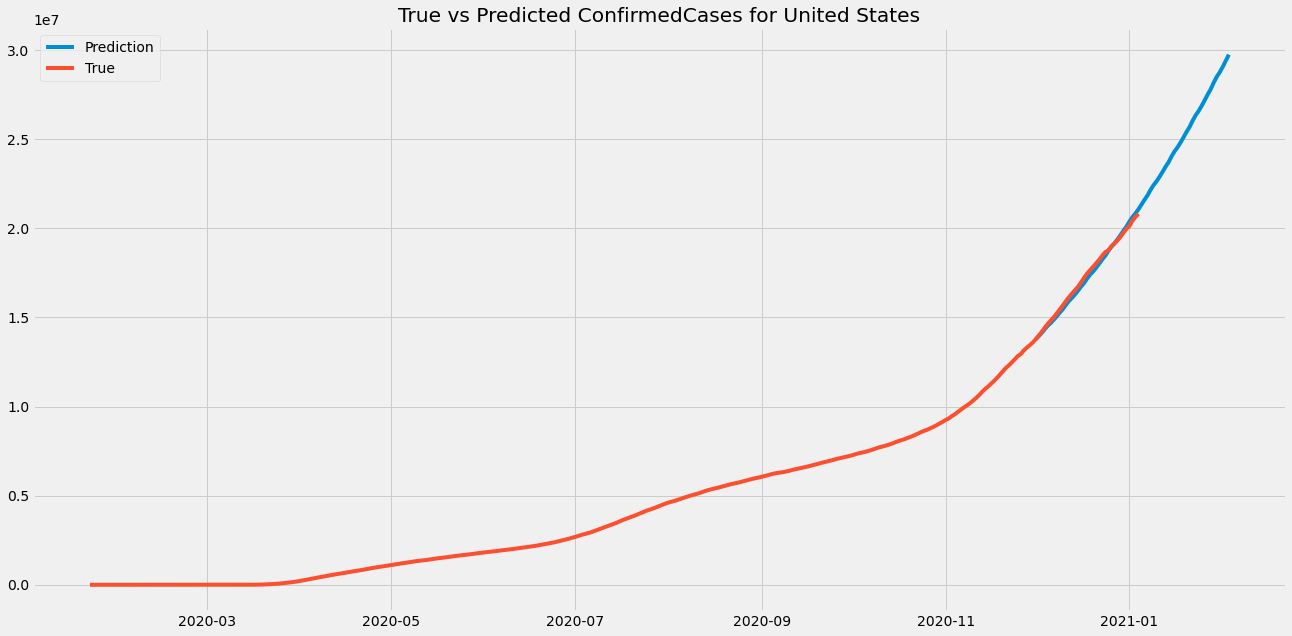

In [379]:
model2 = SARIMAX(cbrt_train, order = (0,2,0), seasonal_order = (3,2,1,7),
                                       freq = 'D')
fit_model2 = model2.fit(maxiter = 200, disp = False)
yhat = fit_model2.forecast(len(test)+30)**3
mpe = mean_percent_error(test,yhat)
print(f'mpe = {mpe}')

plt.plot(yhat, label='Prediction')
plt.plot(true, label='True')
plt.legend()
plt.title(f'True vs Predicted {prediction} for {region}')
plt.savefig('SARIMA_prediction2021_01_05.png')
pickle.dump(fit_model2, open('SARIMAX_fit_model2.pickle', 'wb'))

In [374]:
test

Date
2020-12-01    13791945.0
2020-12-02    13992765.0
2020-12-03    14212649.0
2020-12-04    14442788.0
2020-12-05    14658875.0
2020-12-06    14840269.0
2020-12-07    15030195.0
2020-12-08    15249204.0
2020-12-09    15471133.0
2020-12-10    15698737.0
2020-12-11    15933420.0
2020-12-12    16152668.0
2020-12-13    16344409.0
2020-12-14    16538023.0
2020-12-15    16735333.0
2020-12-16    16982157.0
2020-12-17    17219177.0
2020-12-18    17468841.0
2020-12-19    17665284.0
2020-12-20    17853731.0
2020-12-21    18045048.0
2020-12-22    18239758.0
2020-12-23    18466484.0
2020-12-24    18665343.0
2020-12-25    18765529.0
2020-12-26    18992126.0
2020-12-27    19142603.0
2020-12-28    19309281.0
2020-12-29    19511426.0
2020-12-30    19740772.0
2020-12-31    19968087.0
2021-01-01    20128693.0
2021-01-02    20426184.0
2021-01-03    20636663.0
2021-01-04    20817140.0
Freq: D, Name: ConfirmedCases, dtype: float64

The large error on Nov. 26th was because of Thanksgiving.  Fewer people were testing on Thanksgiving, or fewer people were working in the labs.  The increased errors between Nov. 9th and November 26th may be because of increased testing as people prepared to travel for the holiday.  Errors decrease again after this period.

In [327]:
from pmdarima import auto_arima

auto_arima(y=train, start_p=0, start_d=1, start_q=0, 
           max_p=6, max_d=2, max_q=4, 
           seasonal=True, trace=True, D=None, n_jobs=-1, 
           with_intercept=False,suppress_warnings=True, error_action='ignore',
           out_of_sample_size = 0, 
          start_P=0, start_D=0, start_Q=0,
           max_P=7, max_D=2, max_Q=7,
          m=7)

C:\Users\caell\new_Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:74: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-238.930, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7]             : AIC=-300.494, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7]             : AIC=-271.781, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=-236.942, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[7]             : AIC=-325.800, Time=0.15 sec
 ARIMA(1,1,0)(3,0,0)[7]             : AIC=-338.446, Time=0.26 sec
 ARIMA(1,1,0)(4,0,0)[7]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(3,0,1)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(1,1,0)(2,0,1)[7]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(4,0,1)[7]             : AIC=-355.065, Time=1.44 sec
 ARIMA(1,1,0)(5,0,1)[7]             : AIC=-351.120, Time=2.79 sec
 ARIMA(1,1,0)(4,0,2)[7]             : AIC=inf, Time=1.80 sec
 ARIMA(1,1,0)(3,0,2)[7]             : AIC=inf, Time=1.16 sec
 ARIMA(1,1,0)(5,0,0)[7]             : AIC=inf, Time=1.85 sec
 ARIMA(1,1,0)(5,0,2)[7]             : AIC=-356.847, Time=4.13 s

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(5, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

In [315]:
model2 = SARIMAX(train, order =(1,1,4), seasonal_order = (4,0,0,7),
                                       freq = 'D')

TypeError: __new__() got an unexpected keyword argument 'seasonal_order'

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE = 263662.92369540187


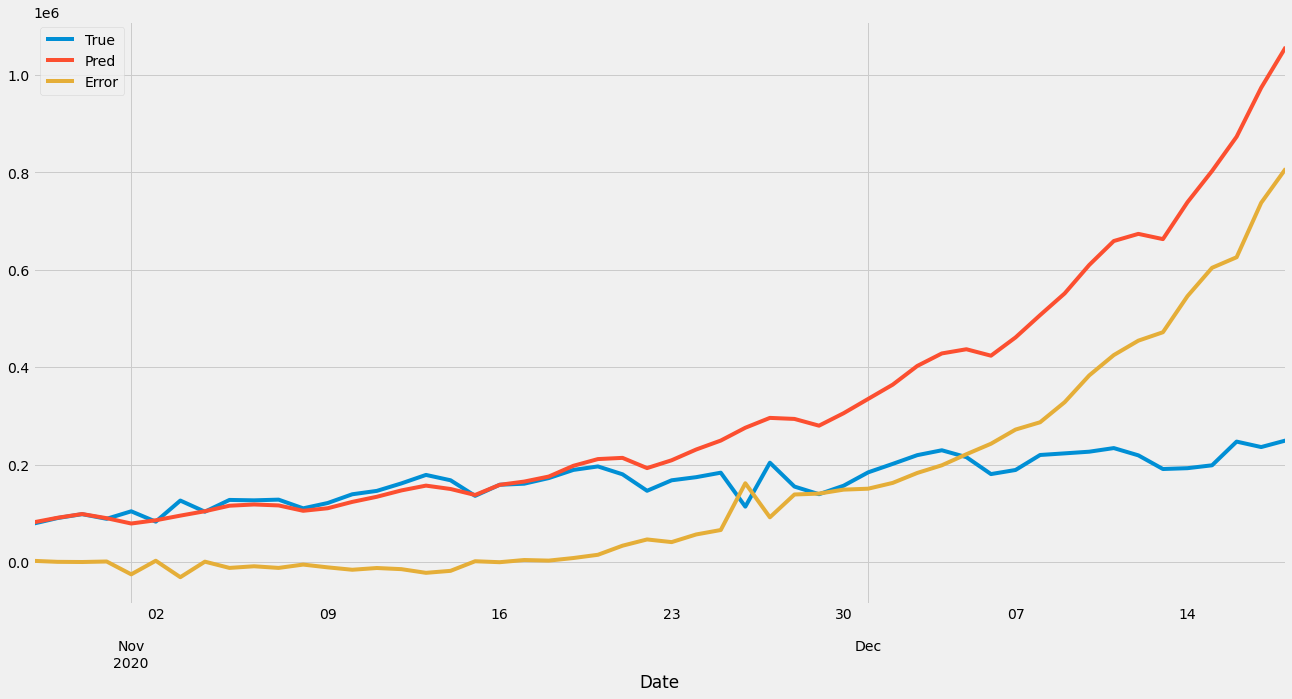

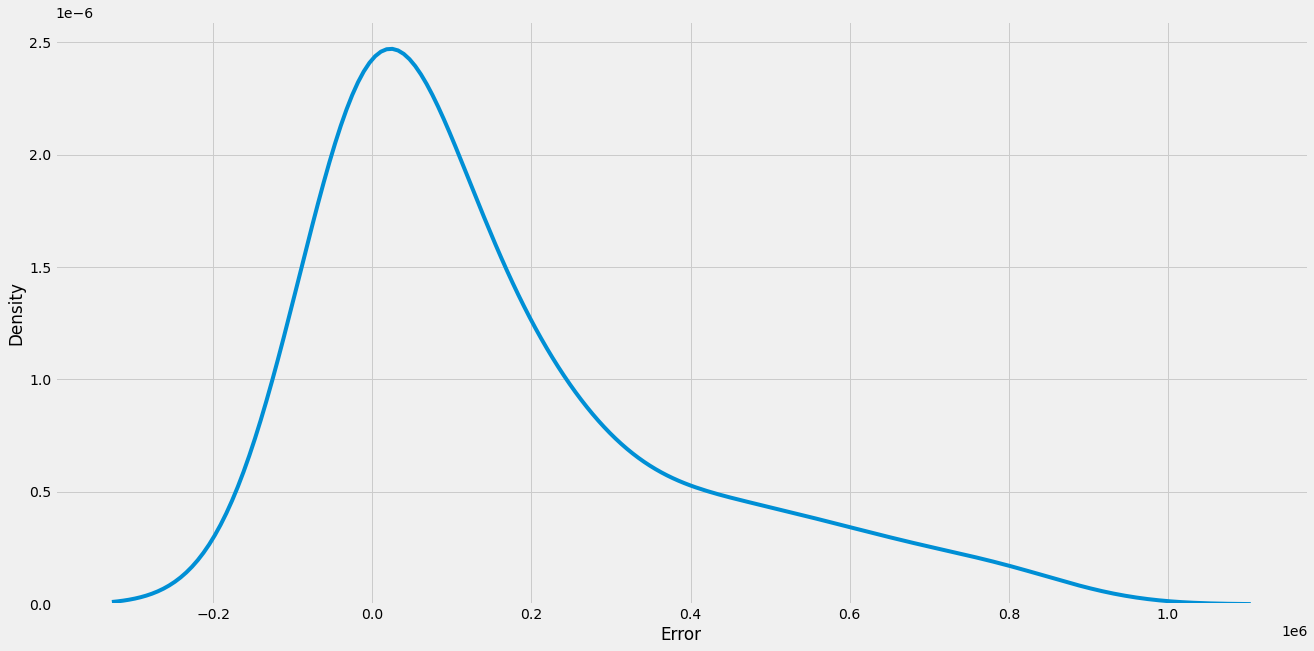

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           NewCases   No. Observations:                  210
Model:             SARIMAX(5, 2, 3)x(4, 0, [], 7)   Log Likelihood                 167.736
Date:                            Wed, 23 Dec 2020   AIC                           -305.471
Time:                                    10:56:25   BIC                           -255.408
Sample:                                04-01-2020   HQIC                          -285.228
                                     - 10-27-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0012      0.008     -0.148      0.883      -0.017       0.015
drift       1.107e-05   6.97e-05      0.159      0.874      -0.000       0.000
ar.L1         -0.7597      0.539     -1.410      0.159      -1.816       0.297
ar.L2         -0.6795      0.415     -1.636      0.102      -1.493       0.134
ar.L3         -0.6268      0.275     -2.276      0.023      -1.167      -0.087
ar.L4         -0.5414      0.214     -2.525      0.012      -0.962      -0.121
ar.L5         -0.3427      0.140     -2.442      0.015      -0.618      -0.068
ma.L1         -0.3973      0.537     -0.740      0.459      -1.450       0.655
ma.L2          0.0068      0.424      0.016      0.987      -0.824       0.837
ma.L3          0.0531      0.245      0.217      0.828      -0.427       0.533
ar.S.L7        0.1136      0.154      0.737      0.461      -0.188       0.416
ar.S.L14       0.1415      0.087      1.636      0.102      -0.028       0.311
ar.S.L21       0.1296      0.083      1.561      0.118      -0.033       0.292
ar.S.L28       0.3000      0.079      3.787      0.000       0.145       0.455
sigma2         0.0113      0.001      8.389      0.000       0.009       0.014
===================================================================================
Ljung-Box (Q):                       72.20   Jarque-Bera (JB):                 2.35
Prob(Q):                              0.00   Prob(JB):                         0.31
Heteroskedasticity (H):               1.76   Skew:                            -0.16
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [391]:
model3 = SARIMAX(train,order=(5, 2, 3), seasonal_order=(4, 0, 0, 7),
      suppress_warnings=True, trend='ct')
fit_model3 = model3.fit()
yhat = fit_model3.forecast(len(test))
RMSE = eval_model(fit_model3,test,yhat)
print(f'RMSE = {RMSE}')

test_pred = pd.DataFrame()
test_pred['True'] = np.exp(test)
test_pred['Pred'] = np.exp(yhat)
test_pred['Error'] = (np.exp(yhat)-np.exp(test))
test_pred.plot(figsize = (20,10))
plt.show()
sns.kdeplot(test_pred['Error'])
plt.show()
fit_model3.summary()

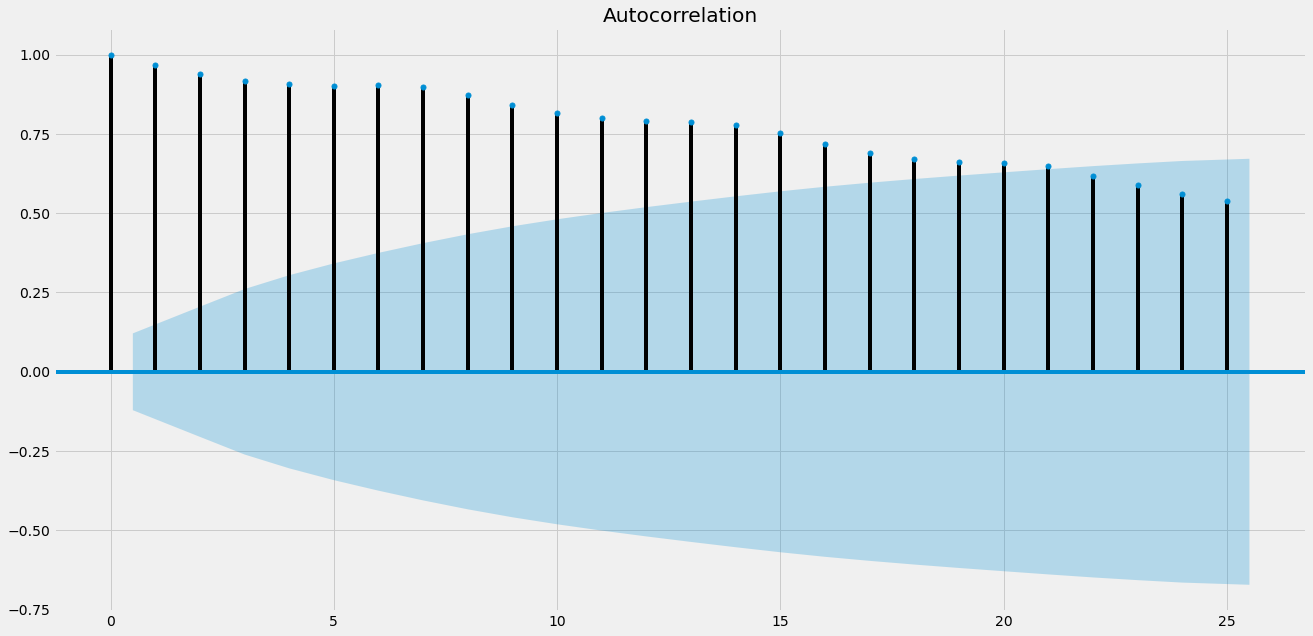

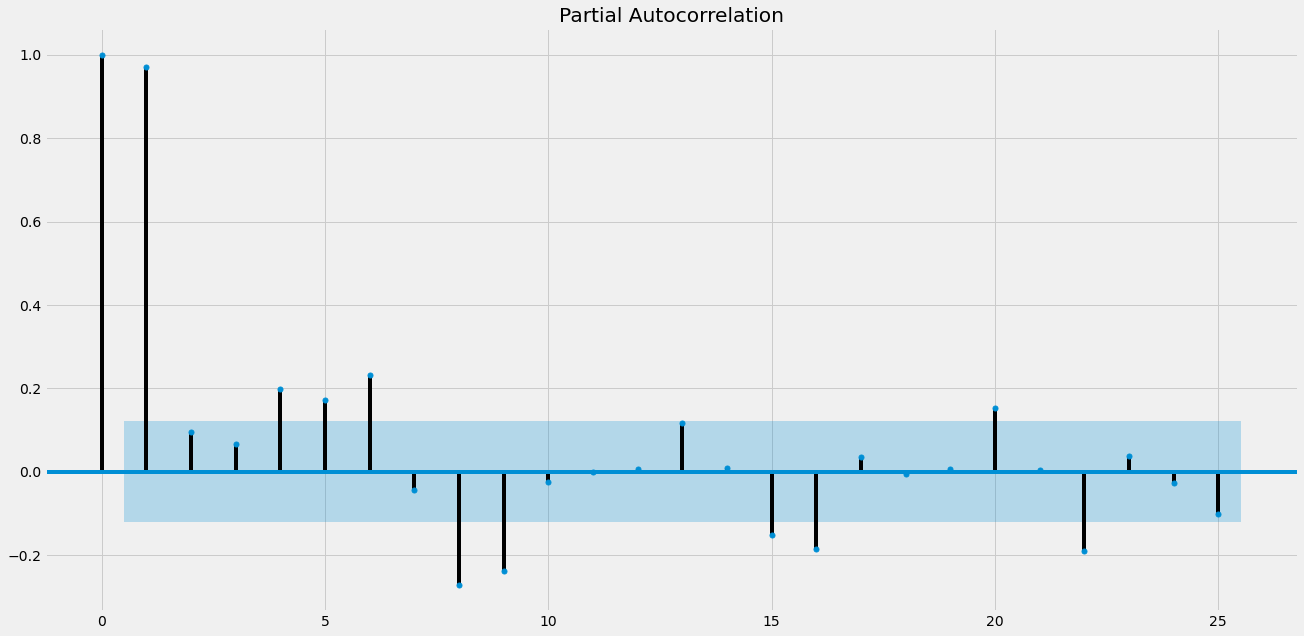

In [378]:
plot_acf(true.dropna())
plt.show()
plot_pacf(true.dropna())
plt.show()